In [1]:
import pandas as pd 
import numpy as np
import csv
from builtins import open, bytes
import gensim
from gensim.utils import simple_preprocess
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import gensim.corpora as corpora
nltk.download('stopwords')
from deep_translator import GoogleTranslator
from langdetect import detect
import seaborn as sns
from recordlinkage.standardise import clean
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package stopwords to /Users/chris/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# initialize the sentiment analyzer 
sid = SentimentIntensityAnalyzer()

# create the function to calculate the sentiment score, on a scale of [-1,1], as 1 is most positive 
def sentiment_score(text):
    return sid.polarity_scores(text)['compound']

In [3]:
china = pd.read_csv('/Users/chris/Desktop/Thesis/public_opinion_thesis/Data/china_translated.csv')
iran = pd.read_csv('/Users/chris/Desktop/Thesis/public_opinion_thesis/Data/iran_translated.csv')
nk = pd.read_csv('/Users/chris/Desktop/Thesis/public_opinion_thesis/Data/nk_translated.csv')
russia = pd.read_csv('/Users/chris/Desktop/Thesis/public_opinion_thesis/Data/russia_translated.csv')

In [4]:
china['sentiment'] = china['translated'].apply(sentiment_score)
iran['sentiment'] = iran['translated'].apply(sentiment_score)
nk['sentiment'] = nk['translated'].apply(sentiment_score)
russia['sentiment'] = russia['translated'].apply(sentiment_score)

## Data Analysis

In [5]:
# Map month names to numbers, assuming 'month' contains short month names
def date_convert(china):    
    month_map = {
        'Jan': '01', 'Feb': '02', 'Mar': '03', 'Apr': '04', 'May': '05', 'Jun': '06',
        'Jul': '07', 'Aug': '08', 'Sep': '09', 'Oct': '10', 'Nov': '11', 'Dec': '12'
    }

    china['month'] = china['month'].map(month_map)
    china['year'] = china['year'].astype(int).astype(str)

    # Create 'year_month' column
    china['year_month'] = china['year']
    # + '-' + china['month'] 

    # remove uncessary columns
    china.drop(columns=['day','year','Unnamed: 0'],inplace=True)
    return china

In [6]:
china = date_convert(china)
iran = date_convert(iran)
russia = date_convert(russia)
nk = date_convert(nk)

In [7]:
countries = pd.concat([china,iran,nk,russia],axis=0)
countries.sort_values('year_month')

,orig_text,url,user_id_str,month,translated,country,sentiment,year_month,Unnamed: 0.1,ulr
0,pmoindia narendramodi turned tables china good...,https://twitter.com/Jaya462/status/99110477607...,2.898726e+08,04,pmoindia narendramodi turned tables china good...,china,0.4404,2018,NaN,NaN
67,dont quick give trump credit north korea says ...,https://twitter.com/AdamBKushner/status/990991...,2.411250e+07,04,dont quick give trump credit north korea says ...,nk,0.7430,2018,67.0,NaN
66,update us president donald trump suggests summ...,https://twitter.com/AFP/status/990976570620829696,3.806486e+08,04,update us president donald trump suggests summ...,nk,0.0000,2018,66.0,NaN
65,thecurrentcbc much anna marie trumphater hates...,https://twitter.com/Canadas_Awesome/status/990...,9.399362e+17,04,thecurrentcbc much anna marie trumphater hates...,nk,-0.7096,2018,65.0,NaN
64,interview peace advocate former us diplomat an...,https://twitter.com/democracynow/status/990941...,1.693529e+07,04,interview peace advocate former us diplomat an...,nk,0.8555,2018,64.0,NaN
...,...,...,...,...,...,...,...,...,...,...
10061,iran oman hold joint naval drill,https://twitter.com/EurasiaReview/status/17303...,2.185618e+07,11,iran oman hold joint naval drill,iran,0.0000,2023,NaN,NaN
10062,witcohe bak want iran govern gaza,https://twitter.com/TiredOldManinAL/status/173...,1.690059e+18,11,witcohe bak want iran govern gaza,iran,0.0772,2023,NaN,NaN
10063,die westliche untersttzung fr demokratie im ir...,https://twitter.com/malthawr/status/1730374150...,2.733212e+08,11,die westliche untersttzung fr demokratie im ir...,iran,-0.9136,2023,NaN,NaN
10065,visegrad24 apsanabegummp try say iran,https://twitter.com/EndeavourOV_105/status/173...,2.409729e+09,11,visegrad24 apsanabegummp try say iran,iran,0.0000,2023,NaN,NaN


In [8]:
import pandas as pd

# Function to calculate the percentage of negative sentiment scores
def percentage_negative(scores):
    negative_count = scores[scores < 0].count()  # Count negative scores
    percentage = (negative_count / len(scores)) * 100  # Calculate percentage
    return percentage

countries['year'] = countries['year_month']

# Calculate the yearly standard deviation of sentiment scores for each country
yearly_std_dev = countries.groupby(['year', 'country'])['sentiment'].std().reset_index(name='yearly_std_dev')

# Flag negative sentiment scores
countries['is_negative'] = countries['sentiment'] < 0

# Calculate the percentage of negative sentiment scores for each month and country
monthly_negative_percentage = countries.groupby(['year','country'])['is_negative'].mean() * 100
monthly_negative_percentage = monthly_negative_percentage.reset_index(name='negative_percentage')

# Merge the monthly negative percentage DataFrame with the yearly standard deviation DataFrame on 'year' and 'country'
final_df = pd.merge(monthly_negative_percentage, yearly_std_dev, on=['year', 'country'])

# Calculate the final value for each row by multiplying the negative percentage by the yearly standard deviation
final_df['value'] = final_df['negative_percentage'] * final_df['yearly_std_dev']

# Pivot the table to get each 'country' as separate columns and 'year-month' as rows
pivot_table1 = final_df.pivot_table(index=['year'], columns='country', values='value').reset_index()

# Display the final pivot table
print(pivot_table1)


country  year      china       iran         nk     russia
0        2018   9.701731  14.744392  18.215136  22.074276
1        2019  12.665063  15.822195  20.606756  18.923398
2        2020  16.393098  14.993171  20.411271  21.121493
3        2021  11.965132  10.701064  20.062495  19.724326
4        2022  13.168985  12.003285  19.924310  23.368858
5        2023  15.597115  13.201819  21.102813  25.752494


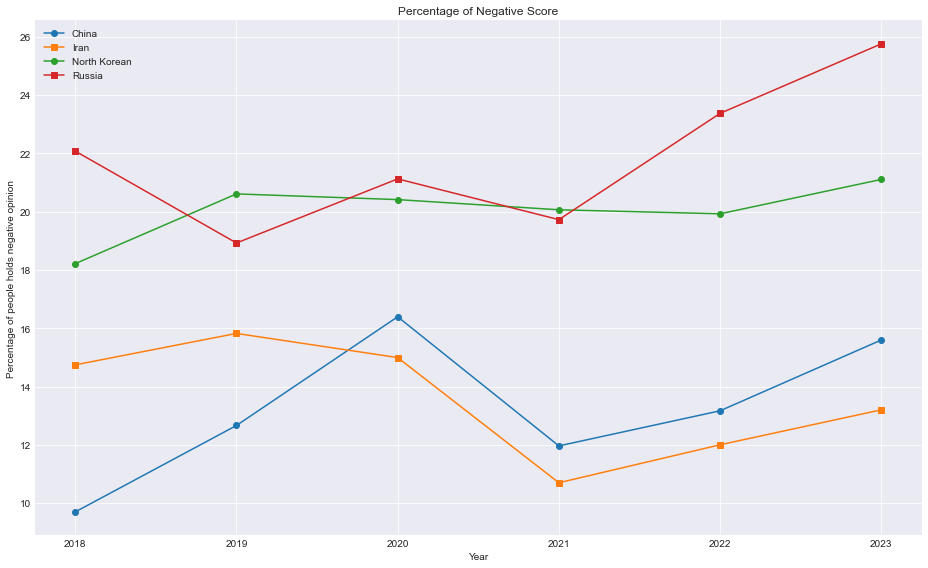

In [9]:
import matplotlib.pyplot as plt
# Setting the style
plt.style.use('seaborn-darkgrid')

# Extract the year from 'year_month' and create a new column 'year'
# pivot_table['year'] = pivot_table['year_month'].str[:4]

# Group by 'year' and calculate the mean sentiment scores again
annual_means1 = pivot_table1.groupby('year').mean().reset_index()

# Plotting
plt.figure(figsize=(13,8))  # Set the figure size for better readability
plt.plot(annual_means1['year'], annual_means1['china'], marker='o', label='China')
plt.plot(annual_means1['year'], annual_means1['iran'], marker='s', label='Iran')
plt.plot(annual_means1['year'], annual_means1['nk'], marker='o', label='North Korean')
plt.plot(annual_means1['year'], annual_means1['russia'], marker='s', label='Russia')

# Adding titles and labels
plt.title('Percentage of Negative Score')
plt.xlabel('Year')
plt.ylabel('Percentage of people holds negative opinion')
plt.legend()  # Show the legend to indicate which line corresponds to which country

# Show the plot
plt.tight_layout()  # Adjust the layout to make room for the labels
plt.show()


In [10]:
grouped = countries.groupby(['year_month', 'country']).sentiment.mean().reset_index()
pivot_table2 = grouped.pivot(index='year_month', columns='country', values='sentiment').reset_index()
pivot_table2.columns.name = None  # Removes the name 'country' from the columns
pivot_table2 = pivot_table2.rename(columns={'China': 'china', 'Iran': 'iran','Russia': 'russia','North Korean': 'nk'})

print(pivot_table2)

  year_month     china      iran        nk    russia
0       2018  0.046001 -0.023713  0.007625 -0.075164
1       2019  0.033290 -0.042258 -0.046267 -0.003832
2       2020 -0.043876 -0.038373 -0.026841 -0.027481
3       2021  0.007878 -0.026175 -0.016163 -0.017394
4       2022  0.027034 -0.040627 -0.031465 -0.086668
5       2023 -0.016123 -0.049062 -0.052239 -0.108010


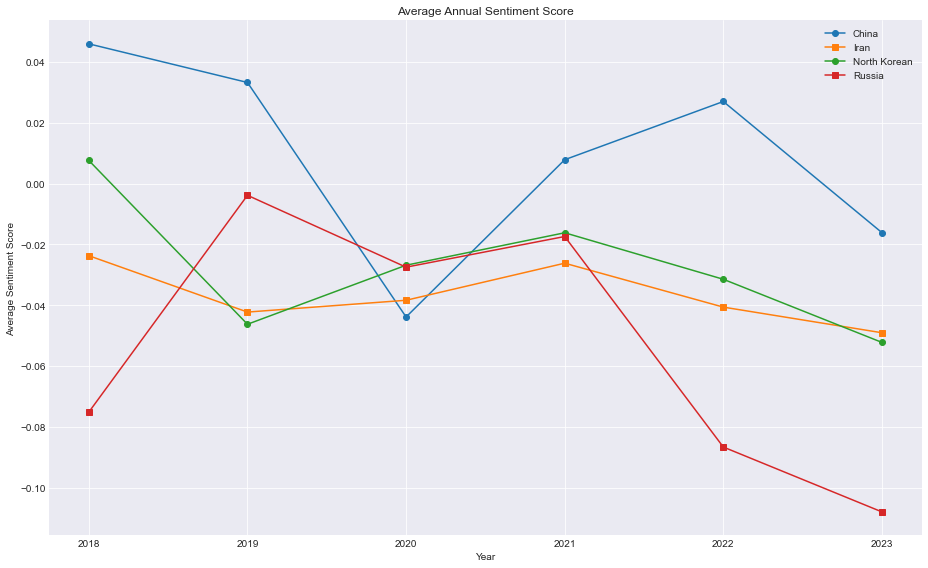

In [11]:
import matplotlib.pyplot as plt
# Setting the style
plt.style.use('seaborn-darkgrid')

# Extract the year from 'year_month' and create a new column 'year'
pivot_table2['year'] = pivot_table2['year_month'].str[:4]

# Group by 'year' and calculate the mean sentiment scores again
annual_means2 = pivot_table2.groupby('year').mean().reset_index()

# Plotting
plt.figure(figsize=(13,8))  # Set the figure size for better readability
plt.plot(annual_means2['year'], annual_means2['china'], marker='o', label='China')
plt.plot(annual_means2['year'], annual_means2['iran'], marker='s', label='Iran')
plt.plot(annual_means2['year'], annual_means2['nk'], marker='o', label='North Korean')
plt.plot(annual_means2['year'], annual_means2['russia'], marker='s', label='Russia')

# Adding titles and labels
plt.title('Average Annual Sentiment Score')
plt.xlabel('Year')
plt.ylabel('Average Sentiment Score')
plt.legend()  # Show the legend to indicate which line corresponds to which country

# Show the plot
plt.tight_layout()  # Adjust the layout to make room for the labels
plt.show()


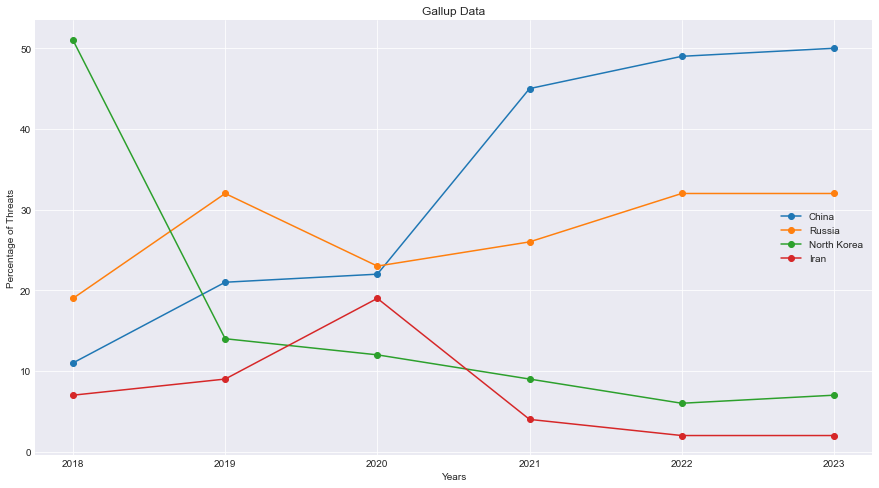

In [12]:
gallup3 = pd.read_csv("/Users/chris/Desktop/Thesis/public_opinion_thesis/Data/gallup_cleaned.csv")
# Setting the style
plt.style.use('seaborn-darkgrid')

# Create a color palette
palette = plt.get_cmap('tab10')  # Using 'tab10' for a broad range of distinct colors

fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(gallup3.iloc[4:,1], gallup3.iloc[4:,2],marker='o', label='China')
ax.plot(gallup3.iloc[4:,1], gallup3.iloc[4:,3],marker='o', label='Russia')
ax.plot(gallup3.iloc[4:,1], gallup3.iloc[4:,4],marker='o', label='North Korea')
ax.plot(gallup3.iloc[4:,1], gallup3.iloc[4:,5],marker='o', label='Iran')

ax.set_xlabel('Years')
ax.set_ylabel('Percentage of Threats')
ax.set_title('Gallup Data')
ax.legend()

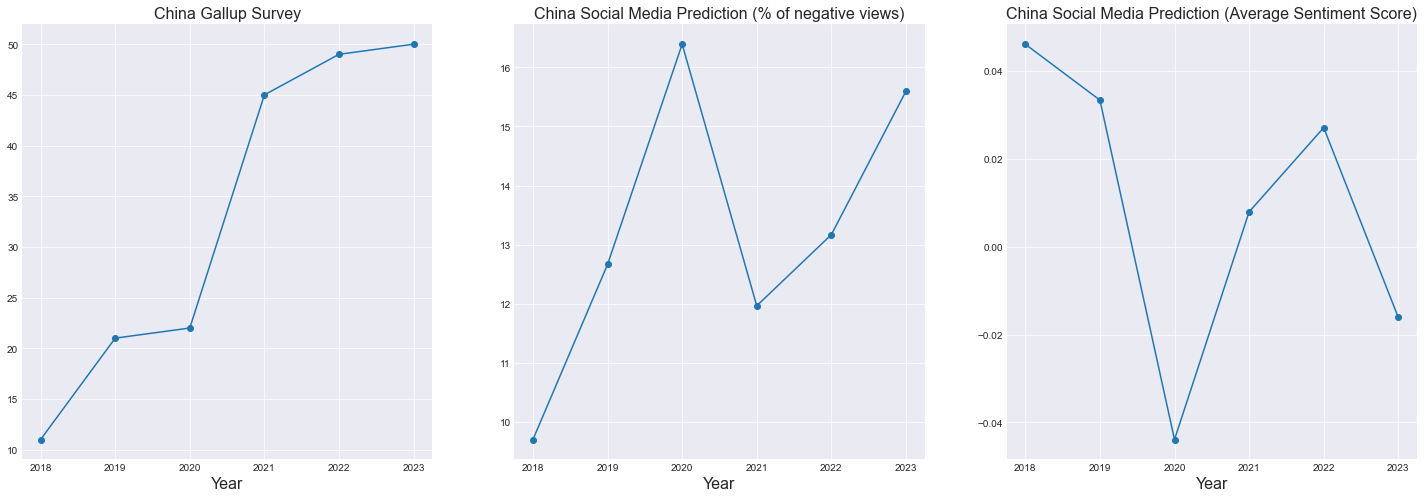

In [13]:
fig, axs = plt.subplots(1,3, figsize=(25, 8))
palette = plt.get_cmap('tab10')  # Using 'tab10' for a broad range of distinct colors

axs[0].plot(gallup3.iloc[4:,1], gallup3.iloc[4:,2],marker='o', label='China')
axs[0].set_xlabel('Year', fontsize=16)
axs[0].set_title('China Gallup Survey', fontsize=16)

axs[1].plot(annual_means1['year'], annual_means1['china'], marker='o', label='China_sm')
axs[1].set_xlabel('Year', fontsize=16)
axs[1].set_title('China Social Media Prediction (% of negative views)', fontsize=16)

axs[2].plot(annual_means2['year'], annual_means2['china'], marker='o', label='China_sm')
axs[2].set_xlabel('Year', fontsize=16)
axs[2].set_title('China Social Media Prediction (Average Sentiment Score)', fontsize=16)

ax.set_xlabel('Years')
ax.set_ylabel('Percentage of Threats')
ax.legend()

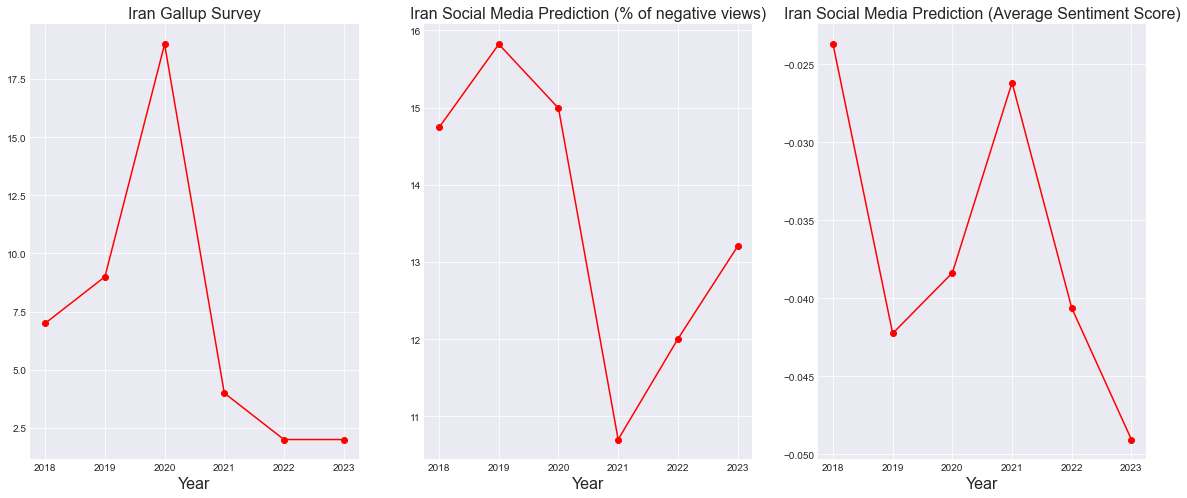

In [14]:
fig, axs = plt.subplots(1,3, figsize=(20, 8))
palette = plt.get_cmap('tab10')  # Using 'tab10' for a broad range of distinct colors

axs[0].plot(gallup3.iloc[4:,1], gallup3.iloc[4:,5],marker='o', label='iran', color = 'r')
axs[0].set_xlabel('Year', fontsize=16)
axs[0].set_title('Iran Gallup Survey', fontsize=16)

axs[1].plot(annual_means1['year'], annual_means1['iran'], marker='o', label='iran',color = 'r')
axs[1].set_xlabel('Year', fontsize=16)
axs[1].set_title('Iran Social Media Prediction (% of negative views)', fontsize=16)

axs[2].plot(annual_means2['year'], annual_means2['iran'], marker='o', label='iran',color = 'r')
axs[2].set_xlabel('Year', fontsize=16)
axs[2].set_title('Iran Social Media Prediction (Average Sentiment Score)', fontsize=16)

ax.set_xlabel('Years')
ax.set_ylabel('Percentage of Threats')
ax.legend()

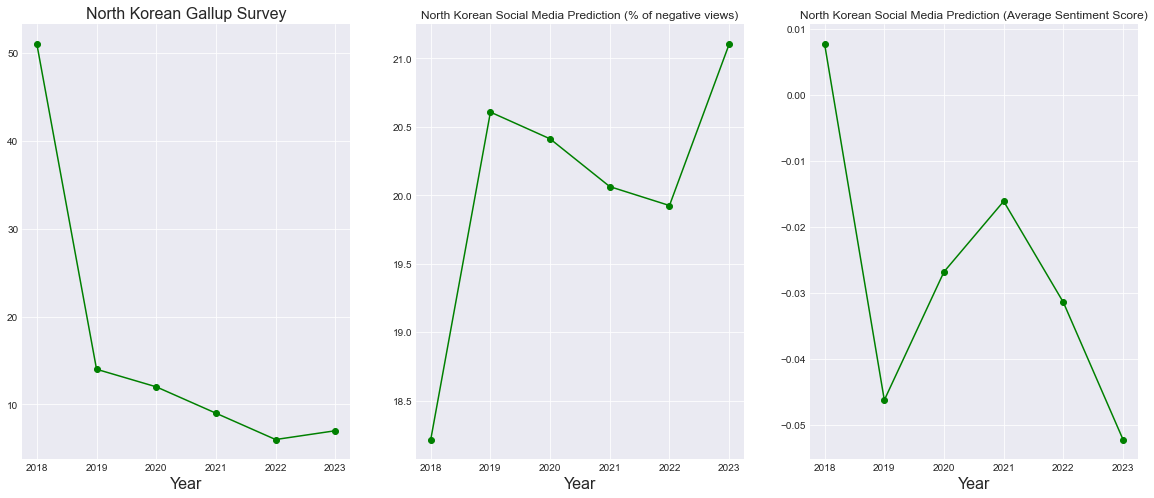

In [15]:
fig, axs = plt.subplots(1,3, figsize=(20, 8))
palette = plt.get_cmap('tab10')  # Using 'tab10' for a broad range of distinct colors

axs[0].plot(gallup3.iloc[4:,1], gallup3.iloc[4:,4],marker='o', label='North Korean', color = 'g')
axs[0].set_xlabel('Year', fontsize=16)
axs[0].set_title('North Korean Gallup Survey', fontsize=16)

axs[1].plot(annual_means1['year'], annual_means1['nk'], marker='o', label='north korean',color = 'g')
axs[1].set_xlabel('Year', fontsize=16)
axs[1].set_title('North Korean Social Media Prediction (% of negative views)', fontsize=12)

axs[2].plot(annual_means2['year'], annual_means2['nk'], marker='o', label='north korean',color = 'g')
axs[2].set_xlabel('Year', fontsize=16)
axs[2].set_title('North Korean Social Media Prediction (Average Sentiment Score)', fontsize=12)

ax.set_xlabel('Years')
ax.set_ylabel('Percentage of Threats')
ax.legend()

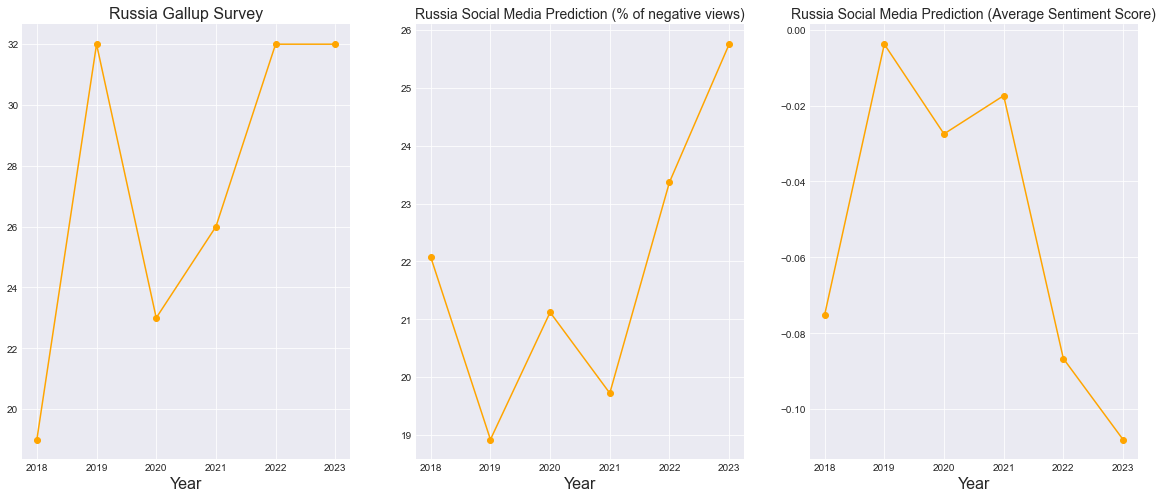

In [16]:
fig, axs = plt.subplots(1,3, figsize=(20, 8))
palette = plt.get_cmap('tab10')  # Using 'tab10' for a broad range of distinct colors

axs[0].plot(gallup3.iloc[4:,1], gallup3.iloc[4:,3],marker='o', label='Russia', color = 'orange')
axs[0].set_xlabel('Year', fontsize=16)
axs[0].set_title('Russia Gallup Survey', fontsize=16)

axs[1].plot(annual_means1['year'], annual_means1['russia'], marker='o', label='Russia',color = 'orange')
axs[1].set_xlabel('Year', fontsize=16)
axs[1].set_title('Russia Social Media Prediction (% of negative views)', fontsize=14)

axs[2].plot(annual_means2['year'], annual_means2['russia'], marker='o', label='Russia',color = 'orange')
axs[2].set_xlabel('Year', fontsize=16)
axs[2].set_title('Russia Social Media Prediction (Average Sentiment Score)', fontsize=14)

ax.set_xlabel('Years')
ax.set_ylabel('Percentage of Threats')
ax.legend()

### Sentiment Score Distribution 

Text(0.5, 1.0, 'Russia Sentiment distribution')

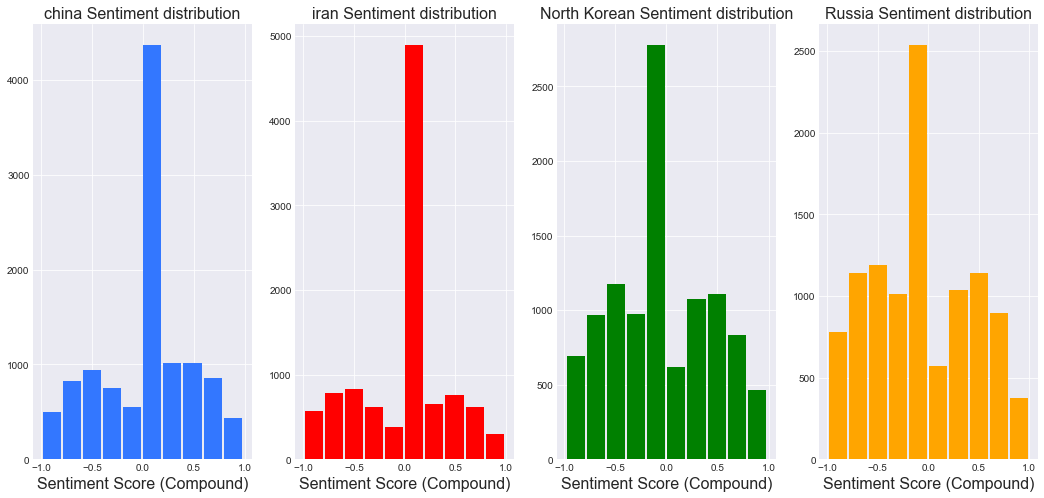

In [17]:
fig, axs = plt.subplots(1,4, figsize=(18, 8))
axs[0].hist(china['sentiment'],histtype='bar', facecolor='#3377FF', rwidth=0.9)
axs[0].set_xlabel('Sentiment Score (Compound)', fontsize=16)
axs[0].set_title('china Sentiment distribution', fontsize=16)

axs[1].hist(iran['sentiment'],histtype='bar', facecolor='red', rwidth=0.9)
axs[1].set_xlabel('Sentiment Score (Compound)', fontsize=16)
axs[1].set_title('iran Sentiment distribution', fontsize=16)

axs[2].hist(nk['sentiment'],histtype='bar', facecolor='green', rwidth=0.9)
axs[2].set_xlabel('Sentiment Score (Compound)', fontsize=16)
axs[2].set_title('North Korean Sentiment distribution', fontsize=16)

axs[3].hist(russia['sentiment'],histtype='bar', facecolor='orange', rwidth=0.9)
axs[3].set_xlabel('Sentiment Score (Compound)', fontsize=16)
axs[3].set_title('Russia Sentiment distribution', fontsize=16)

## Topic Modeling

In [55]:
china_2021 = china[china['year_month']=='2021']
china_2022 = china[china['year_month']=='2022']

Text(0.5, 1.0, 'China Sentiment distribution 2022')

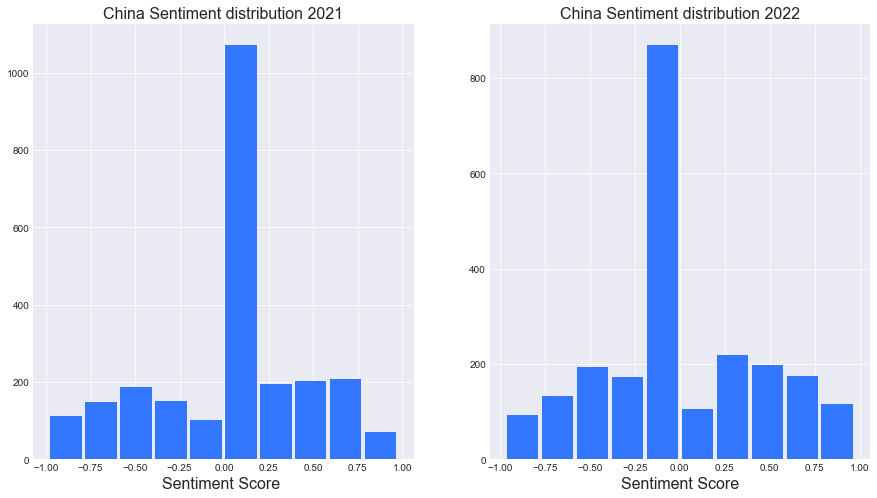

In [146]:
fig, axs = plt.subplots(1,2, figsize=(15, 8))
axs[0].hist(china_2021['sentiment'],histtype='bar', facecolor='#3377FF', rwidth=0.9)
axs[0].set_xlabel('Sentiment Score ', fontsize=16)
axs[0].set_title('China Sentiment distribution 2021', fontsize=16)

axs[1].hist(china_2022['sentiment'],histtype='bar', facecolor='#3377FF', rwidth=0.9)
axs[1].set_xlabel('Sentiment Score', fontsize=16)
axs[1].set_title('China Sentiment distribution 2022', fontsize=16)

In [74]:
iran_2022 = iran[iran['year_month']=='2022']
iran_2023 = iran[iran['year_month']=='2023']

Text(0.5, 1.0, 'Iran Sentiment distribution 2023')

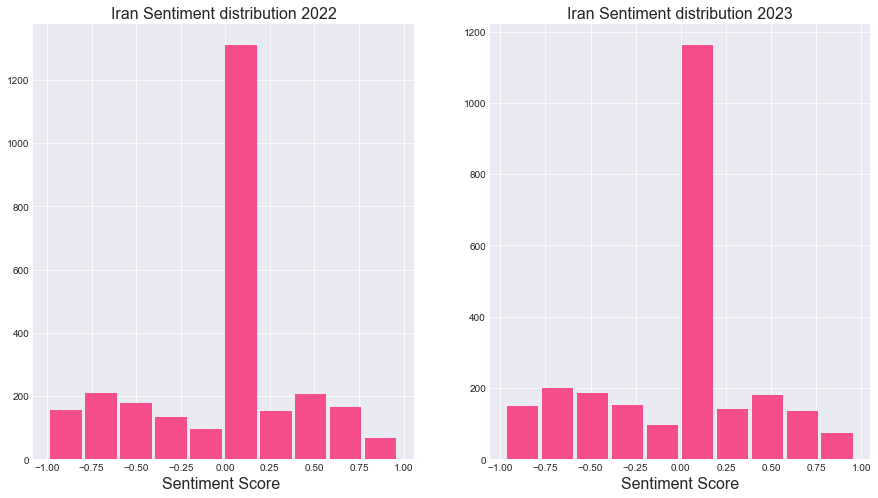

In [147]:
fig, axs = plt.subplots(1,2, figsize=(15, 8))
axs[0].hist(iran_2022['sentiment'],histtype='bar', facecolor='#F64E8B', rwidth=0.9)
axs[0].set_xlabel('Sentiment Score ', fontsize=16)
axs[0].set_title('Iran Sentiment distribution 2022', fontsize=16)

axs[1].hist(iran_2023['sentiment'],histtype='bar', facecolor='#F64E8B', rwidth=0.9)
axs[1].set_xlabel('Sentiment Score', fontsize=16)
axs[1].set_title('Iran Sentiment distribution 2023', fontsize=16)

Text(0.5, 1.0, 'North Korean Sentiment distribution 2023')

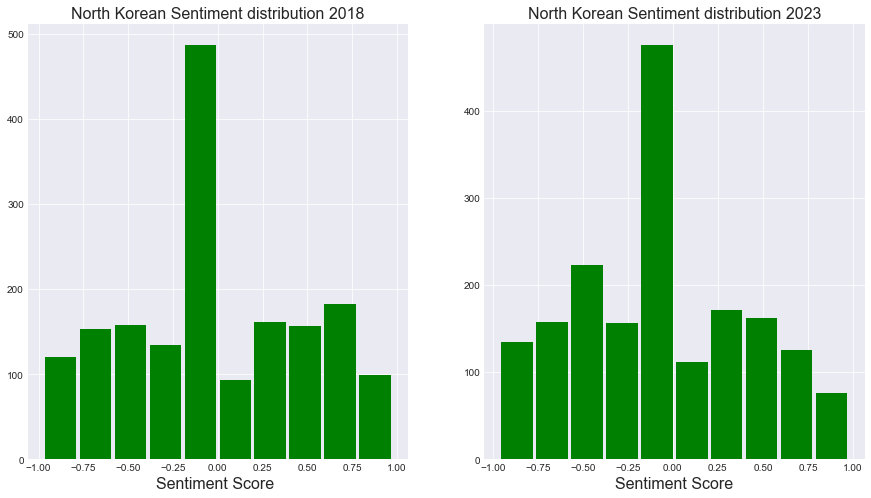

In [19]:
nk_2018 = nk[nk['year_month']=='2018']
nk_2023 = nk[nk['year_month']=='2023']

fig, axs = plt.subplots(1,2, figsize=(15, 8))
axs[0].hist(nk_2018['sentiment'],histtype='bar', facecolor='green', rwidth=0.9)
axs[0].set_xlabel('Sentiment Score ', fontsize=16)
axs[0].set_title('North Korean Sentiment distribution 2018', fontsize=16)

axs[1].hist(nk_2023['sentiment'],histtype='bar', facecolor='green', rwidth=0.9)
axs[1].set_xlabel('Sentiment Score', fontsize=16)
axs[1].set_title('North Korean Sentiment distribution 2023', fontsize=16)

Text(0.5, 1.0, 'Russia Sentiment distribution 2021')

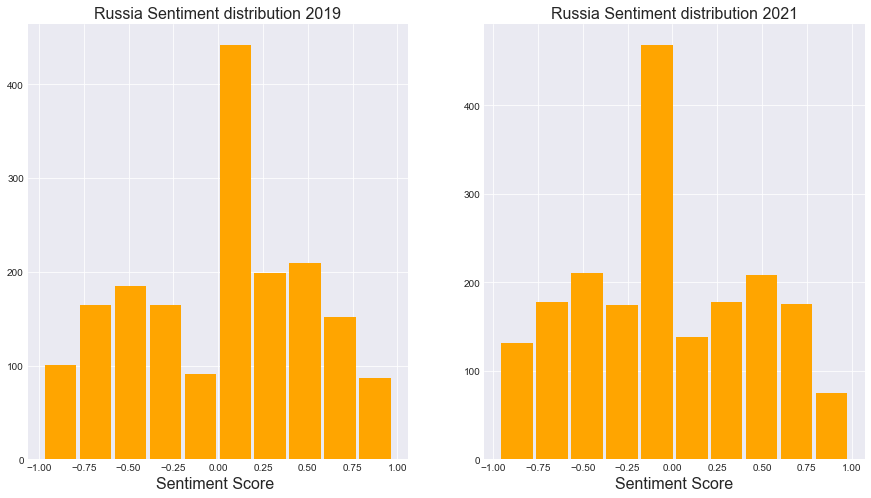

In [29]:
ru_2019 = russia[russia['year_month']=='2019']
ru_2021 = russia[russia['year_month']=='2021']

fig, axs = plt.subplots(1,2, figsize=(15, 8))
axs[0].hist(ru_2019['sentiment'],histtype='bar', facecolor='orange', rwidth=0.9)
axs[0].set_xlabel('Sentiment Score ', fontsize=16)
axs[0].set_title('Russia Sentiment distribution 2019', fontsize=16)

axs[1].hist(ru_2021['sentiment'],histtype='bar', facecolor='orange', rwidth=0.9)
axs[1].set_xlabel('Sentiment Score', fontsize=16)
axs[1].set_title('Russia Sentiment distribution 2021', fontsize=16)

### China 2021

In [89]:
china_2021_1 = china_2021[china_2021['sentiment']<0.25]
china_2021_2 = china_2021_1[china_2021_1['sentiment']>0]
china_2021_2.iloc[0:15].sort_values(by='sentiment', ascending=False)

,orig_text,url,user_id_str,month,translated,country,sentiment,year_month
1620,leo829418 preciso ser muito idiota pra acredit...,https://twitter.com/ninguem_anyone/status/1366...,2.700300e+09,02,leo829418 you have to be a very idiot to belie...,china,0.2271,2021
1484,uma curiosidade aqui na china drago smbolo bom...,https://twitter.com/nicaksks/status/1388281007...,7.521990e+17,04,"It's a curiosity here in China, the dragon is ...",china,0.2263,2021
1544,mfelten25 maxabrahms think china probably okay...,https://twitter.com/parasolstand/status/143285...,1.327598e+18,08,mfelten25 maxabrahms think china probably okay...,china,0.2263,2021
1517,chinita ix hey china lo mismo hago yo verga ni...,https://twitter.com/boss_1063/status/143285528...,8.670956e+17,08,"chinita ix hey china I do the same thing, don'...",china,0.2235,2021
1584,revistaoeste informaes da china comunista muit...,https://twitter.com/isantanna54/status/1366176...,8.244157e+17,02,magazineoeste information from communist china...,china,0.2232,2021
1606,fui china depot el espritu de comprar cosas in...,https://twitter.com/luispee1/status/1366175891...,2.725534e+08,02,I went to china depot the spirit of buying unn...,china,0.1779,2021
1618,cidade que teve primeiro caso de covid19 na ch...,https://twitter.com/aalinemoura2000/status/136...,1.104785e+18,02,The city that had the first case of covid19 in...,china,0.1706,2021
1489,jorgeesteve8 carsalomone francholandia octavio...,https://twitter.com/Lomas2214/status/138828099...,8.590308e+17,04,jorgeesteve8 carsalomone francoland octaviocri...,china,0.1531,2021
1463,tn eua alegam que china tem falhado com compro...,https://twitter.com/Fonte_TradeNews/status/138...,3.632484e+08,04,tn usa allege china has failed to meet intelle...,china,0.1280,2021
1628,showdavida precisamos de conscincia respeitar ...,https://twitter.com/HighlinderR/status/1366175...,2.555798e+09,02,showdavida we need conscience to respect the r...,china,0.1263,2021


In [163]:
# Topic Modeling 
# Create a TF-IDF vectorizer to convert the text data to a matrix of TF-IDF features
vectorizer = TfidfVectorizer(stop_words='english', 
                             use_idf=True, 
                             smooth_idf=True)

# Fit and transform the vectorizer on the 'translated' column
tfidf_matrix = vectorizer.fit_transform(china_2021_2['translated'])

# Create an LSA model with 8 topics
num_topics = 10
lsa_model = TruncatedSVD(n_components=num_topics)

# Fit the LSA model on the TF-IDF matrix
lsa_topic_matrix = lsa_model.fit_transform(tfidf_matrix)

# Get the feature names from the vectorizer's vocabulary
feature_names = vectorizer.get_feature_names_out()

# Print the top words for each of the 10 topics
for i, comp in enumerate(lsa_model.components_):
    terms_comp = zip(feature_names, comp)
    sorted_terms = sorted(terms_comp, key=lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print(t[0])
    print("\n")

    # Print the text snippets within the topic
    topic_idx = lsa_topic_matrix[:, i].argsort()[::-1][:5]
    for idx in topic_idx:
        print('original ext: ',china_2021_2.iloc[idx]['orig_text'])
        # print('original tweets: ', month09_df2.iloc[idx]['orig_text'])
    print("\n")

Topic 0: 
china
fine
chinese
dasc839
silly
peril
rich
government
want
usa


original ext:  fine china
original ext:  fine china
original ext:  dasc839 china silly 7
original ext:  dasc839 china silly 7
original ext:  rich peril china


Topic 1: 
chinese
government
want
food
xinjiang
know
workers
nigeria
covid
chinas


original ext:  comida china quiero
original ext:  us commerce secretary gina raimondo dont know boeing heretheres tens billions dollars planes chinese airlines want buy chinese government standing way
original ext:  chinese government ready help nigeria reduce level poverty nation mr cui jianchm chinese ambassador nigeria 
original ext:  chinese government apologists actually believed marxist philosophy claim support would fighting release chinese marxist student organizers amp factory workers disappeared ccp daring organize workers rights
original ext:  chinese lawyer chenqiushi forcibly disappeared chinese government reporting early stages covid pandemic 2020 suddenly r

### China 2022

In [159]:
china_2022_1 = china_2021[china_2021['sentiment']> 0]
# china_2022_2 = china_2021_1[china_2021_1['sentiment']> -0.25]
china_2022_1.iloc[0:15].sort_values(by='sentiment', ascending=False)

,orig_text,url,user_id_str,month,translated,country,sentiment,year_month
1429,china bernal jajaja es que si le tiraban duro ...,https://twitter.com/julioretana92/status/13882...,2.169966e+09,04,china bernal hahaha the thing is that if they ...,china,0.9136,2021
1441,kokooooocrunch dowoon sama luoyan nah yg ganti...,https://twitter.com/Dear6__/status/13882817381...,3.230473e+09,04,"kokooooocrunch dowoon and luoyan, well, replac...",china,0.7269,2021
1434,ciudadanolevi1 chinaconozco la versin moderna ...,https://twitter.com/FerCangrejo/status/1388281...,1.730539e+09,04,citizenlevi1 chinaI know the modern version bu...,china,0.7227,2021
1459,keikofujimori china gana renuncia limpiaras tu...,https://twitter.com/NeuronaAchorada/status/138...,4.233495e+07,04,keikofujimori china wins resignation you will ...,china,0.6249,2021
1462,keikofujimori vamos con todo china eres una gr...,https://twitter.com/alxi60/status/138828151027...,1.868317e+08,04,keikofujimori let's go with everything china y...,china,0.6249,2021
1443,aqu en la china lunes domingo maana madrugada ...,https://twitter.com/marialepg_/status/13882817...,1.051358e+09,04,here in China Monday Sunday morning early afte...,china,0.5994,2021
1432,rittner daniel teve um da islndia que impediu ...,https://twitter.com/colunadoct/status/13882818...,2.903057e+07,04,rittner daniel had one from iceland that preve...,china,0.5719,2021
1469,floriromeroo china queridasomos pocos son poco...,https://twitter.com/EnsoVozdelMonu/status/1388...,1.106927e+09,04,"floriromeroo china dear, we are few, there are...",china,0.5574,2021
1427,niksnoppesnada quinsding milanknol oh dat uw l...,https://twitter.com/RichJG4/status/13882819449...,1.195532e+18,04,nothingnoppesnada quinsding milanknol oh that ...,china,0.4595,2021
1439,todo el mundo tendr acceso la educacin en chin...,https://twitter.com/RadioTemplo/status/1388281...,1.171166e+08,04,Everyone will have access to education in Chin...,china,0.4404,2021


In [162]:
# Topic Modeling 
# Create a TF-IDF vectorizer to convert the text data to a matrix of TF-IDF features
vectorizer = TfidfVectorizer(stop_words='english', 
                             use_idf=True, 
                             smooth_idf=True)

# Fit and transform the vectorizer on the 'translated' column
tfidf_matrix = vectorizer.fit_transform(china_2022_1['translated'])

# Create an LSA model with 8 topics
num_topics = 10
lsa_model = TruncatedSVD(n_components=num_topics)

# Fit the LSA model on the TF-IDF matrix
lsa_topic_matrix = lsa_model.fit_transform(tfidf_matrix)

# Get the feature names from the vectorizer's vocabulary
feature_names = vectorizer.get_feature_names_out()

# Print the top words for each of the 10 topics
for i, comp in enumerate(lsa_model.components_):
    terms_comp = zip(feature_names, comp)
    sorted_terms = sorted(terms_comp, key=lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print(t[0])
    print("\n")

    # Print the text snippets within the topic
    topic_idx = lsa_topic_matrix[:, i].argsort()[::-1][:5]
    for idx in topic_idx:
        print('orig_text: ',china_2022_1.iloc[idx]['orig_text'])
        # print('original tweets: ', month09_df2.iloc[idx]['orig_text'])
    print("\n")

Topic 0: 
china
chinese
government
like
communist
party
people
amp
chinas
world


orig_text:  well thats tens chinese family dont live china doesnt fear chinese government may
orig_text:  opinion chinese people 100 reasons celebrate 100th anniversary founding communist party china thursday cpc100  
orig_text:  july 1 100th anniversary chinese communist party party amp people see china amp place world story predates 1921 techreview write chinas path modernization lives two men hometown
orig_text:  hong kong public broadcaster told must support chinese government  course media already supports chinese government
orig_text:  100th anniversary founding communist party china 


Topic 1: 
chinese
government
food
defeat
uyghurs
hong
fan
course
kong
festival


orig_text:  chinese government could never defeat
orig_text:  hong kong public broadcaster told must support chinese government  course media already supports chinese government
orig_text:  dont worry everyone hate chinese government 
or

### Iran 2022

In [87]:
iran_2022_1 = iran_2022[iran_2022['sentiment']<0]
iran_2022_1.iloc[0:15].sort_values(by='sentiment', ascending=False)

,url,orig_text,user_id_str,month,translated,country,sentiment,year_month
2995,https://twitter.com/elpescador23/status/152055...,ninii aponte89 que nos irn quitar,1.460655e+08,04,ninii aponte89 who will pay us off,iran,-0.1027,2022
3001,https://twitter.com/MonmondeJV/status/15205508...,restitutororien dans ton classement du moyen o...,1.436066e+18,04,restitutororien in your classification of the ...,iran,-0.2263,2022
2992,https://twitter.com/TraderMx2/status/152055148...,mexateco despues de esto si antes aunque tena ...,1.241848e+18,04,Mexateco after this yes before although he had...,iran,-0.2675,2022
2983,https://twitter.com/SaMyVIi/status/15205522368...,ggvanrom jeanmariepetit azralth kurororinho ju...,3.837543e+09,04,ggvanrom jeanmariepetit azralth kurororinho ju...,iran,-0.2960,2022
3020,https://twitter.com/lourderlin/status/15205491...,juancar38428371 lo de maana ser distopa al reg...,1.178107e+18,04,juancar38428371 tomorrow will be dystopia when...,iran,-0.4767,2022
3028,https://twitter.com/juangohu/status/1520548555...,comunicacionec ahora esos delincuentes que pue...,2.840830e+08,04,comunicacionec now those criminals who can car...,iran,-0.5106,2022
2970,https://twitter.com/DaengWahidin2/status/15205...,dd05207376 penikmatko pi lakum dinukuum waliya...,1.401837e+18,04,dd05207376 penikmatko pi lakum dinukuum waliya...,iran,-0.6326,2022
3005,https://twitter.com/Arestop/status/15205502869...,faraona1975 algunos estn jodidosy el chantaje ...,2.707595e+08,04,faraona1975 some are screwed and the module's ...,iran,-0.6705,2022
3010,https://twitter.com/ChNADEEMASLAM3/status/1520...,nadeemmalik fitna nay pakistan ko lapait liya ...,1.268798e+18,04,nadeemmalik fitna nay pakistan ko liyait hai b...,iran,-0.7096,2022
2985,https://twitter.com/DiarioTalCual/status/15205...,transportistas advierten que irn paro en prote...,1.475891e+08,04,Transporters warn that they will go on strike ...,iran,-0.7906,2022


In [83]:
# Topic Modeling 
# Create a TF-IDF vectorizer to convert the text data to a matrix of TF-IDF features
vectorizer = TfidfVectorizer(stop_words='english', 
                             use_idf=True, 
                             smooth_idf=True)

# Fit and transform the vectorizer on the 'translated' column
tfidf_matrix = vectorizer.fit_transform(iran_2022_1['translated'])

# Create an LSA model with 10 topics
num_topics = 10
lsa_model = TruncatedSVD(n_components=num_topics)

# Fit the LSA model on the TF-IDF matrix
lsa_topic_matrix = lsa_model.fit_transform(tfidf_matrix)

# Get the feature names from the vectorizer's vocabulary
feature_names = vectorizer.get_feature_names_out()

# Print the top words for each of the 10 topics
for i, comp in enumerate(lsa_model.components_):
    terms_comp = zip(feature_names, comp)
    sorted_terms = sorted(terms_comp, key=lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print(t[0])
    print("\n")

    # Print the text snippets within the topic
    topic_idx = lsa_topic_matrix[:, i].argsort()[::-1][:5]
    for idx in topic_idx:
        print('translated: ',iran_2022_1.iloc[idx]['translated'])
        # print('original tweets: ', month09_df2.iloc[idx]['orig_text'])
    print("\n")

Topic 0: 
gallent
mahsaplease
protesting
moral
opiran
yo
girl
murdered
mahsa
amini


translated:  mahsa amini twenty two yo girl murdered moral police iran also many gallent people protesting since killing mahsaplease voice opiran
translated:  mahsa amini twenty two yo girl murdered moral police iran also many gallent people protesting since killing mahsaplease voice opiran
translated:  mahsa amini twenty two yo girl murdered moral police iran also many gallent people protesting since killing mahsaplease voice opiran
translated:  mahsa amini twenty two yo girl murdered moral police iran also many gallent people protesting since killing mahsaplease voice opiran
translated:  mahsa amini twenty two yo girl murdered moral police iran also many gallent people protesting since killing mahsaplease voice opiran


Topic 1: 
iran
nuclear
russia
attack
using
war
stops
sites
china
unwatchdog


translated:  iran stops using one nuclear sites attack unwatchdog 
translated:  iran stops using one nucl

### Iran 2023

In [86]:
iran_2023_1 = iran_2023[iran_2023['sentiment']<0]
iran_2023_1.iloc[0:15].sort_values(by='sentiment', ascending=False)

,url,orig_text,user_id_str,month,translated,country,sentiment,year_month
3919,https://twitter.com/L_Badell/status/1652819641...,mjasmin2051 clabetancourt michelcaballero ucra...,1.090242e+08,04,mjasmin2051 clabetancourt michelcaballero Ukra...,iran,-0.0258,2023
3886,https://twitter.com/fragglenemo1/status/165282...,le chef du jihad islamique palestinien au liba...,1.588851e+18,04,the leader of the palestinian islamic jihad in...,iran,-0.2263,2023
3905,https://twitter.com/tpham26863223/status/16528...,us seizure triggers iran commando raid biden b...,1.091427e+18,04,us seizure triggers iran commando raid biden b...,iran,-0.2960,2023
3918,https://twitter.com/_omoide_iran_/status/16528...,first slam dunk,1.201062e+18,04,first slam dunk,iran,-0.3818,2023
3882,https://twitter.com/MigueTom28/status/16528239...,partidopsuv los mismos narcos pudientes de sie...,1.650688e+18,04,partypsuv the same wealthy drug traffickers as...,iran,-0.4404,2023
3896,https://twitter.com/mete_athe/status/165282206...,noktatv24 kanit teshis resim hastane doctor ra...,1.393555e+18,04,"Noktatv24, we want evidence, diagnosis, pictur...",iran,-0.4588,2023
3892,https://twitter.com/JulioCesarSP13/status/1652...,tony2808988 osvaldojn1 liliapachecoda2 conta s...,1.281347e+18,04,tony2808988 osvaldojn1 liliapachecoda2 account...,iran,-0.5994,2023
3893,https://twitter.com/JulioCesarSP13/status/1652...,osvaldojn1 conta sempre feita em dlar principa...,1.281347e+18,04,osvaldojn1 accounts are always done in dollars...,iran,-0.5994,2023
3900,https://twitter.com/JulioCesarSP13/status/1652...,renanglub carlosboide estadao conta sempre fei...,1.281347e+18,04,renanglub carlosboide estadao account is alway...,iran,-0.5994,2023
3910,https://twitter.com/DicleGundogdu/status/16528...,bir iran airi diyor kiez beybn adem ser bzr vc...,1.072582e+18,04,An Iranian poet says kiez beybn adem ser bzr v...,iran,-0.6486,2023


In [90]:
# Topic Modeling 
# Create a TF-IDF vectorizer to convert the text data to a matrix of TF-IDF features
vectorizer = TfidfVectorizer(stop_words='english', 
                             use_idf=True, 
                             smooth_idf=True)

# Fit and transform the vectorizer on the 'translated' column
tfidf_matrix = vectorizer.fit_transform(iran_2023_1['translated'])

# Create an LSA model with 10 topics
num_topics = 10
lsa_model = TruncatedSVD(n_components=num_topics)

# Fit the LSA model on the TF-IDF matrix
lsa_topic_matrix = lsa_model.fit_transform(tfidf_matrix)

# Get the feature names from the vectorizer's vocabulary
feature_names = vectorizer.get_feature_names_out()

# Print the top words for each of the 10 topics
for i, comp in enumerate(lsa_model.components_):
    terms_comp = zip(feature_names, comp)
    sorted_terms = sorted(terms_comp, key=lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print(t[0])
    print("\n")

    # Print the text snippets within the topic
    topic_idx = lsa_topic_matrix[:, i].argsort()[::-1][:5]
    for idx in topic_idx:
        print('translated: ',iran_2023_1.iloc[idx]['translated'])
        # print('original tweets: ', month09_df2.iloc[idx]['orig_text'])
    print("\n")

Topic 0: 
iran
war
russia
israel
ukraine
amp
china
attack
people
world


translated:  bongosaloon likely iran supplying russia ukraine war equipment iran allies russia
translated:  bongosaloon likely iran supplying russia ukraine war equipment iran allies russia
translated:  really want know whats going russia ukraine everything else world war 3 ya gotta check crux news youtubeukraine russia worldwar3 endtimes nato america china northkorea iran israel war 
translated:  world war 3usa russia war iran happynewyear2024 
translated:  ukraine war russia iran invited back nobel prize banquet 


Topic 1: 
russia
war
ukraine
banquet
invited
nobel
prize
korea
china
north


translated:  ukraine war russia iran invited back nobel prize banquet 
translated:  ukraine war russia iran invited back nobel prize banquet 
translated:  ukraine war russia iran invited back nobel prize banquet news bbc 
translated:  bongosaloon likely iran supplying russia ukraine war equipment iran allies russia
translated

### North Korean 2018

In [32]:
nk_2018_1 = nk_2018[nk_2018['sentiment']>0]
# Topic Modeling 
# Create a TF-IDF vectorizer to convert the text data to a matrix of TF-IDF features
vectorizer = TfidfVectorizer(stop_words='english', 
                             use_idf=True, 
                             smooth_idf=True)

# Fit and transform the vectorizer on the 'translated' column
tfidf_matrix = vectorizer.fit_transform(nk_2018_1['translated'])

# Create an LSA model with 10 topics
num_topics = 10
lsa_model = TruncatedSVD(n_components=num_topics)

# Fit the LSA model on the TF-IDF matrix
lsa_topic_matrix = lsa_model.fit_transform(tfidf_matrix)

# Get the feature names from the vectorizer's vocabulary
feature_names = vectorizer.get_feature_names_out()

# Print the top words for each of the 10 topics
for i, comp in enumerate(lsa_model.components_):
    terms_comp = zip(feature_names, comp)
    sorted_terms = sorted(terms_comp, key=lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print(t[0])
    print("\n")

    # Print the text snippets within the topic
    topic_idx = lsa_topic_matrix[:, i].argsort()[::-1][:5]
    for idx in topic_idx:
        print('translated: ',nk_2018_1.iloc[idx]['translated'])
        # print('original tweets: ', month09_df2.iloc[idx]['orig_text'])
    print("\n")

Topic 0: 
kim
korean
north
jong
president
trump
leader
south
government
love


translated:  north korean leader kim jong un sent letter south korean president moon jae calling peace talks 
translated:  north korean leader kim jong un sent letter south korean president moon jae sunday calling peace talks leaders new year 
translated:  n korean leader calls talks south new yearseoul south korea north korean leader kim jong un sent letter south korean president moon jae sunday calling peace talks 
translated:  north korean leader kim jong un sent two dogs south korean president moon jae gift 
translated:  south korean president moon jae praises president trump facilitating talks north koreas kim jong un 


Topic 1: 
government
department
security
homeland
identified
north
cyber
malware
korean
activity


translated:  us department homeland security said identified malicious cyber activity north korean government according new report  
translated:  us department homeland security said ident

### North Korean 2023

In [33]:
nk_2023_1 = nk_2023[nk_2023['sentiment']<0]
# Topic Modeling 
# Create a TF-IDF vectorizer to convert the text data to a matrix of TF-IDF features
vectorizer = TfidfVectorizer(stop_words='english', 
                             use_idf=True, 
                             smooth_idf=True)

# Fit and transform the vectorizer on the 'translated' column
tfidf_matrix = vectorizer.fit_transform(nk_2023_1['translated'])

# Create an LSA model with 10 topics
num_topics = 10
lsa_model = TruncatedSVD(n_components=num_topics)

# Fit the LSA model on the TF-IDF matrix
lsa_topic_matrix = lsa_model.fit_transform(tfidf_matrix)

# Get the feature names from the vectorizer's vocabulary
feature_names = vectorizer.get_feature_names_out()

# Print the top words for each of the 10 topics
for i, comp in enumerate(lsa_model.components_):
    terms_comp = zip(feature_names, comp)
    sorted_terms = sorted(terms_comp, key=lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print(t[0])
    print("\n")

    # Print the text snippets within the topic
    topic_idx = lsa_topic_matrix[:, i].argsort()[::-1][:5]
    for idx in topic_idx:
        print('translated: ',nk_2023_1.iloc[idx]['translated'])
        # print('original tweets: ', month09_df2.iloc[idx]['orig_text'])
    print("\n")

Topic 0: 
north
government
korean
fbi
hackers
korea
stealing
100m
kim
jong


translated:  fbi accuses north korean government hackers stealing 100m harmony bridge theft 
translated:  fbi accuses north korean government hackers stealing 100m harmony bridge theft  
translated:  fbi accuses north korean government hackers stealing 100m harmony bridge theft 
translated:  fbi accuses north korean government hackers stealing 100m harmony bridge theft 
translated:  fbi accuses north korean government hackers stealing 100m harmony bridge theft  


Topic 1: 
fbi
hackers
stealing
100m
bridge
harmony
accuses
theft
100
million


translated:  fbi accuses north korean government hackers stealing 100m harmony bridge theft 
translated:  fbi accuses north korean government hackers stealing 100m harmony bridge theft  
translated:  fbi accuses north korean government hackers stealing 100m harmony bridge theft  
translated:  fbi accuses north korean government hackers stealing 100m harmony bridge theft 
t

### Russia 2019 

In [30]:
ru_2019_1 = ru_2019[ru_2019['sentiment']>0]
# Topic Modeling 
# Create a TF-IDF vectorizer to convert the text data to a matrix of TF-IDF features
vectorizer = TfidfVectorizer(stop_words='english', 
                             use_idf=True, 
                             smooth_idf=True)

# Fit and transform the vectorizer on the 'translated' column
tfidf_matrix = vectorizer.fit_transform(ru_2019_1['translated'])

# Create an LSA model with 10 topics
num_topics = 10
lsa_model = TruncatedSVD(n_components=num_topics)

# Fit the LSA model on the TF-IDF matrix
lsa_topic_matrix = lsa_model.fit_transform(tfidf_matrix)

# Get the feature names from the vectorizer's vocabulary
feature_names = vectorizer.get_feature_names_out()

# Print the top words for each of the 10 topics
for i, comp in enumerate(lsa_model.components_):
    terms_comp = zip(feature_names, comp)
    sorted_terms = sorted(terms_comp, key=lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print(t[0])
    print("\n")

    # Print the text snippets within the topic
    topic_idx = lsa_topic_matrix[:, i].argsort()[::-1][:5]
    for idx in topic_idx:
        print('translated: ',ru_2019_1.iloc[idx]['translated'])
        # print('original tweets: ', month09_df2.iloc[idx]['orig_text'])
    print("\n")

Topic 0: 
russian
trump
government
russia
election
mueller
president
presidential
2016
campaign


translated:  russian government interfered 2016 presidential election sweeping systematic fashion mueller wrote help favored presidential candidate donald j trump disparaged presidential candidate hillary clinton
translated:  russian government interfered 2016 presidential election sweeping systematic fashion mueller wrote help favored presidential candidate donald j trump disparaged presidential candidate hillary clinton
translated:  gopchairwoman realdonaldtrump russian government interfered 2016 presidential election sweeping systematic fashion mueller wrote help favored presidential candidate donald j trump disparaged presidential candidate hillary clintonputinspuppets
translated:  trump jr emailed amp held trump tower meeting conspiring w others illegally obtain election assistance russian government attorney hrc dirt crown prosecutor russia part russians government support trump 
tra

### Russia 2021

In [31]:
ru_2021_1 = ru_2021[ru_2021['sentiment']>0]
# Topic Modeling 
# Create a TF-IDF vectorizer to convert the text data to a matrix of TF-IDF features
vectorizer = TfidfVectorizer(stop_words='english', 
                             use_idf=True, 
                             smooth_idf=True)

# Fit and transform the vectorizer on the 'translated' column
tfidf_matrix = vectorizer.fit_transform(ru_2021_1['translated'])

# Create an LSA model with 10 topics
num_topics = 10
lsa_model = TruncatedSVD(n_components=num_topics)

# Fit the LSA model on the TF-IDF matrix
lsa_topic_matrix = lsa_model.fit_transform(tfidf_matrix)

# Get the feature names from the vectorizer's vocabulary
feature_names = vectorizer.get_feature_names_out()

# Print the top words for each of the 10 topics
for i, comp in enumerate(lsa_model.components_):
    terms_comp = zip(feature_names, comp)
    sorted_terms = sorted(terms_comp, key=lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print(t[0])
    print("\n")

    # Print the text snippets within the topic
    topic_idx = lsa_topic_matrix[:, i].argsort()[::-1][:5]
    for idx in topic_idx:
        print('translated: ',ru_2021_1.iloc[idx]['translated'])
        # print('original tweets: ', month09_df2.iloc[idx]['orig_text'])
    print("\n")

Topic 0: 
russian
government
like
russia
moving
trump
putin
people
love
sounds


translated:  russian government like
translated:  russian government like
translated:  russian government like
translated:  moving like russian government
translated:  moving like russian government


Topic 1: 
russia
love
year
new
happy
ukraine
china
putin
biden
lake


translated:  russia love
translated:  russia love
translated:  russia love
translated:  russia happy new year 
translated:  nickiminaj nicki happy new year russia 


Topic 2: 
like
sounds
love
russia
moving
arkhyz
lake
china
asluhn
drivers


translated:  sounds like russia
translated:  sounds like russia
translated:  sounds like russia
translated:  russian government like
translated:  russian government like


Topic 3: 
year
new
happy
like
nicki
nickiminaj
sounds
moving
plays
happynewyear2022


translated:  russia happy new year 
translated:  nickiminaj nicki happy new year russia
translated:  nickiminaj nicki happy new year russia
translat